In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
class Modele:
    def __init__(self, L):
        self.L = L
        
    def __call__(self, xs) -> float:
        return np.sin(10 * np.pi * xs / self.L) / (1 + np.exp(3 * xs / self.L))
    
    def affichage(self, rep, couleur="blue"):
        xs = np.linspace(0, self.L, 500)
        ys = self(xs)
        rep.plot(xs, ys, label="cible", color=couleur)

In [3]:
mod = Modele(L=5.)
mod(5.)

-5.807994378367547e-17

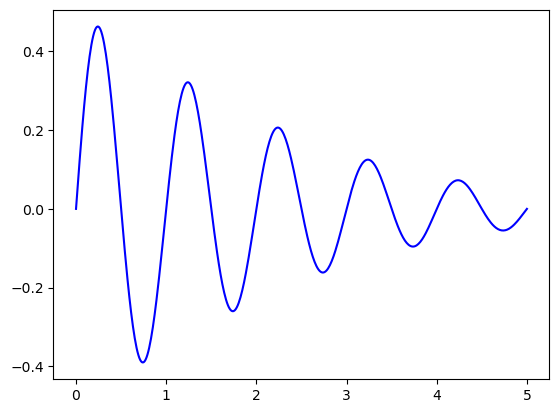

In [4]:
fig, rep = plt.subplots()
mod.affichage(rep)

In [5]:
class Dataset:
    def __init__(self, xk, yk):
        self.xk = xk
        self.yk = yk
        
    def affichage(self, rep, couleur="red"):
        rep.scatter(self.xk, self.yk, color=couleur, label="échantillon")

In [6]:
def mod2ds_simpliste(modele: Modele, N: int) -> Dataset:
    xk = np.linspace(0, modele.L, N+1)
    yk = modele(xk)
    return Dataset(xk=xk, yk=yk)

In [7]:
def mod2ds_simple(modele: Modele, N: int, epsilon: float) -> Dataset:
    xk = np.linspace(0, modele.L, N+1)
    yk = modele(xk) + epsilon * np.random.randn(N+1)
    return Dataset(xk=xk, yk=yk)

In [8]:
def mod2ds(modele: Modele, N: int, epsilon: float) -> Dataset:
    xk = np.random.uniform(low=0., high=modele.L, size=(N+1, ))
    yk = modele(xk) + epsilon * np.random.randn(N+1)
    return Dataset(xk=xk, yk=yk)

In [9]:
mod = Modele(L=5)

Text(0.5, 1.0, 'Version simpliste')

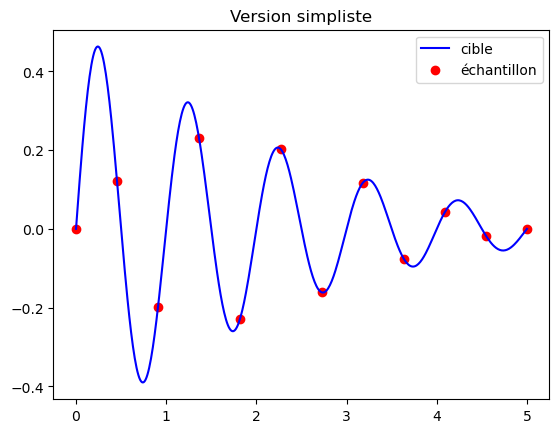

In [10]:
ds1 = mod2ds_simpliste(modele=mod, N=11)

fig, rep = plt.subplots()
mod.affichage(rep)
ds1.affichage(rep)
rep.legend()
rep.set_title("Version simpliste")

Text(0.5, 1.0, 'Version simple')

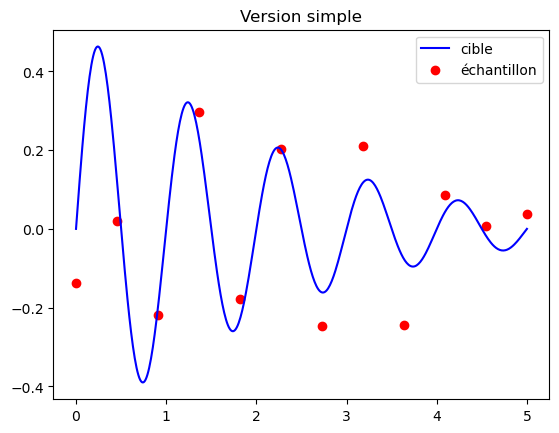

In [11]:
ds2 = mod2ds_simple(modele=mod, N=11, epsilon=0.1)

fig, rep = plt.subplots()
mod.affichage(rep)
ds2.affichage(rep)
rep.legend()
rep.set_title("Version simple")

Text(0.5, 1.0, 'Version simple')

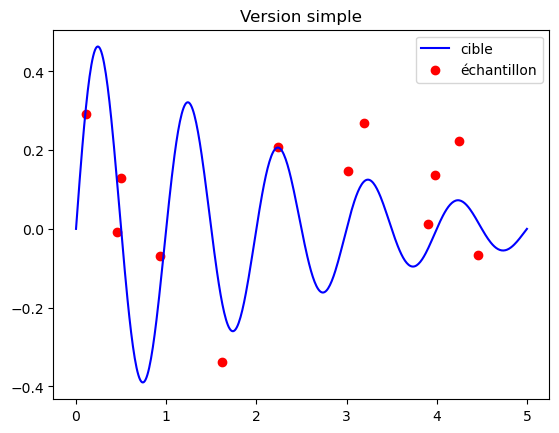

In [12]:
ds3 = mod2ds(modele=mod, N=11, epsilon=0.1)

fig, rep = plt.subplots()
mod.affichage(rep)
ds3.affichage(rep)
rep.legend()
rep.set_title("Version simple")

In [23]:
class Polynome:
    def __init__(self, degre: int):
        if degre < 0:
            raise ValueError("Le degré doit ^etre positif")
        self.degre = degre
        self.coefficients = np.zeros(shape=(degre+1, ))
        
    def __call__(self, x):
        resultat = np.zeros_like(x)
        monome = np.ones_like(x)
        for coef in self.coefficients:
            resultat += coef * monome
            monome = x * monome
        return resultat
        
    def affichage(self, rep, L, couleur="magenta"):
        xs = np.linspace(0, L, 500)
        ys = self(xs)
        rep.plot(xs, ys, label="prédicteur", color=couleur)
        
    def erreur_quadratique(self, ds: Dataset) -> float:
        return np.sum((self(ds.xk) - ds.yk)**2) / len(ds.xk)
    
    def entrainement(self, ds: Dataset):
        def a_minimiser(cs):
            self.coefficients = cs
            return self.erreur_quadratique(ds)
        
        opti_result = minimize(
            fun=a_minimiser,
            x0=self.coefficients,
        )
        if not opti_result.success:
            print("Entrainement Sans succès",)
            print(opti_result.message)
        self.coefficients = opti_result.x
        

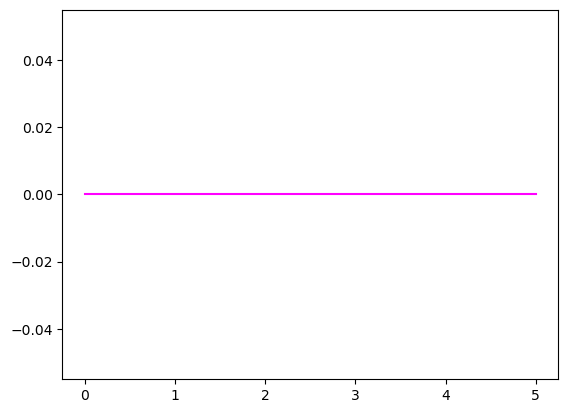

In [24]:
fig, rep = plt.subplots()
poly = Polynome(5)
poly.affichage(rep, 5)

Entrainement Sans succès
Desired error not necessarily achieved due to precision loss.
Erreur quadratique finale: 0.020625948726605062


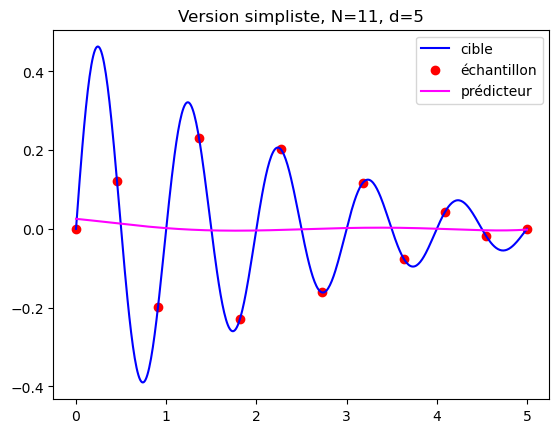

In [25]:
N, d = 11, 5

ds = mod2ds_simpliste(modele=mod, N=N)
poly = Polynome(degre=d)
poly.entrainement(ds)

fig, rep = plt.subplots()
mod.affichage(rep)
ds.affichage(rep)
poly.affichage(rep, mod.L)
rep.legend()
rep.set_title(f"Version simpliste, {N=}, {d=}")
print(f"Erreur quadratique finale: {poly.erreur_quadratique(ds)}")

**EXERCICE**

Faire un graphe avec plusieurs repères où on fait varier le degré du modèle polynomial.

Entrainement Sans succès
Desired error not necessarily achieved due to precision loss.
Entrainement Sans succès
Desired error not necessarily achieved due to precision loss.
Entrainement Sans succès
Desired error not necessarily achieved due to precision loss.


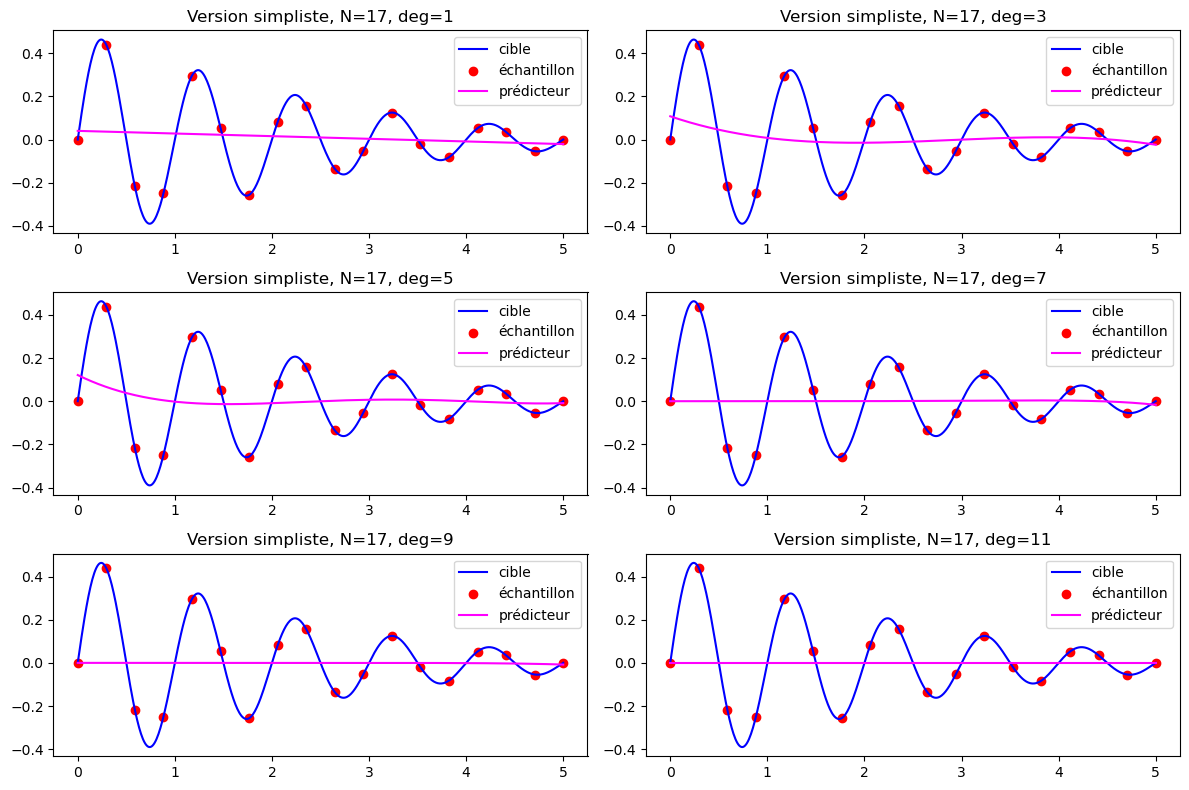

In [28]:
N = 17
ds = mod2ds_simpliste(modele=mod, N=N)

fig, reps = plt.subplots(nrows=3, ncols=2, tight_layout=True, figsize=(12, 8))

for deg, rep in zip((1, 3, 5, 7, 9, 11), reps.flatten()):
    poly = Polynome(degre=deg)
    poly.entrainement(ds)
    mod.affichage(rep)
    ds.affichage(rep)
    poly.affichage(rep, mod.L)
    rep.legend()
    rep.set_title(f"Version simpliste, {N=}, {deg=}")

L'entrainement ne marche pas car les puissancesdans le polynome mènent à une tros grosse perte de précision.

## Variante linéaire généralisée

In [39]:
class Gaussienne:
    def __init__(self, degre: int, L: float):
        if degre < 0:
            raise ValueError("Le degré doit ^etre positif")
        self.degre = degre
        self.coefficients = np.zeros(shape=(degre+1, ))
        self.L = L
        self.points = np.linspace(0, L, degre+1)
        self.phi = lambda x: np.exp(-(x * degre / L) ** 2)
        
    def __call__(self, x):
        return sum(
            coef * self.phi(x - point) 
            for coef, point in zip(self.coefficients, self.points)
        )
        
    def affichage(self, rep, couleur="magenta"):
        xs = np.linspace(0, self.L, 500)
        ys = self(xs)
        rep.plot(xs, ys, label="prédicteur", color=couleur)
        
    def erreur_quadratique(self, ds: Dataset) -> float:
        return np.sum((self(ds.xk) - ds.yk)**2) / len(ds.xk)
    
    def entrainement(self, ds: Dataset):
        def a_minimiser(cs):
            self.coefficients = cs
            return self.erreur_quadratique(ds)
        
        opti_result = minimize(
            fun=a_minimiser,
            x0=self.coefficients,
        )
        if not opti_result.success:
            print("Entrainement Sans succès",)
            print(opti_result.message)
        self.coefficients = opti_result.x

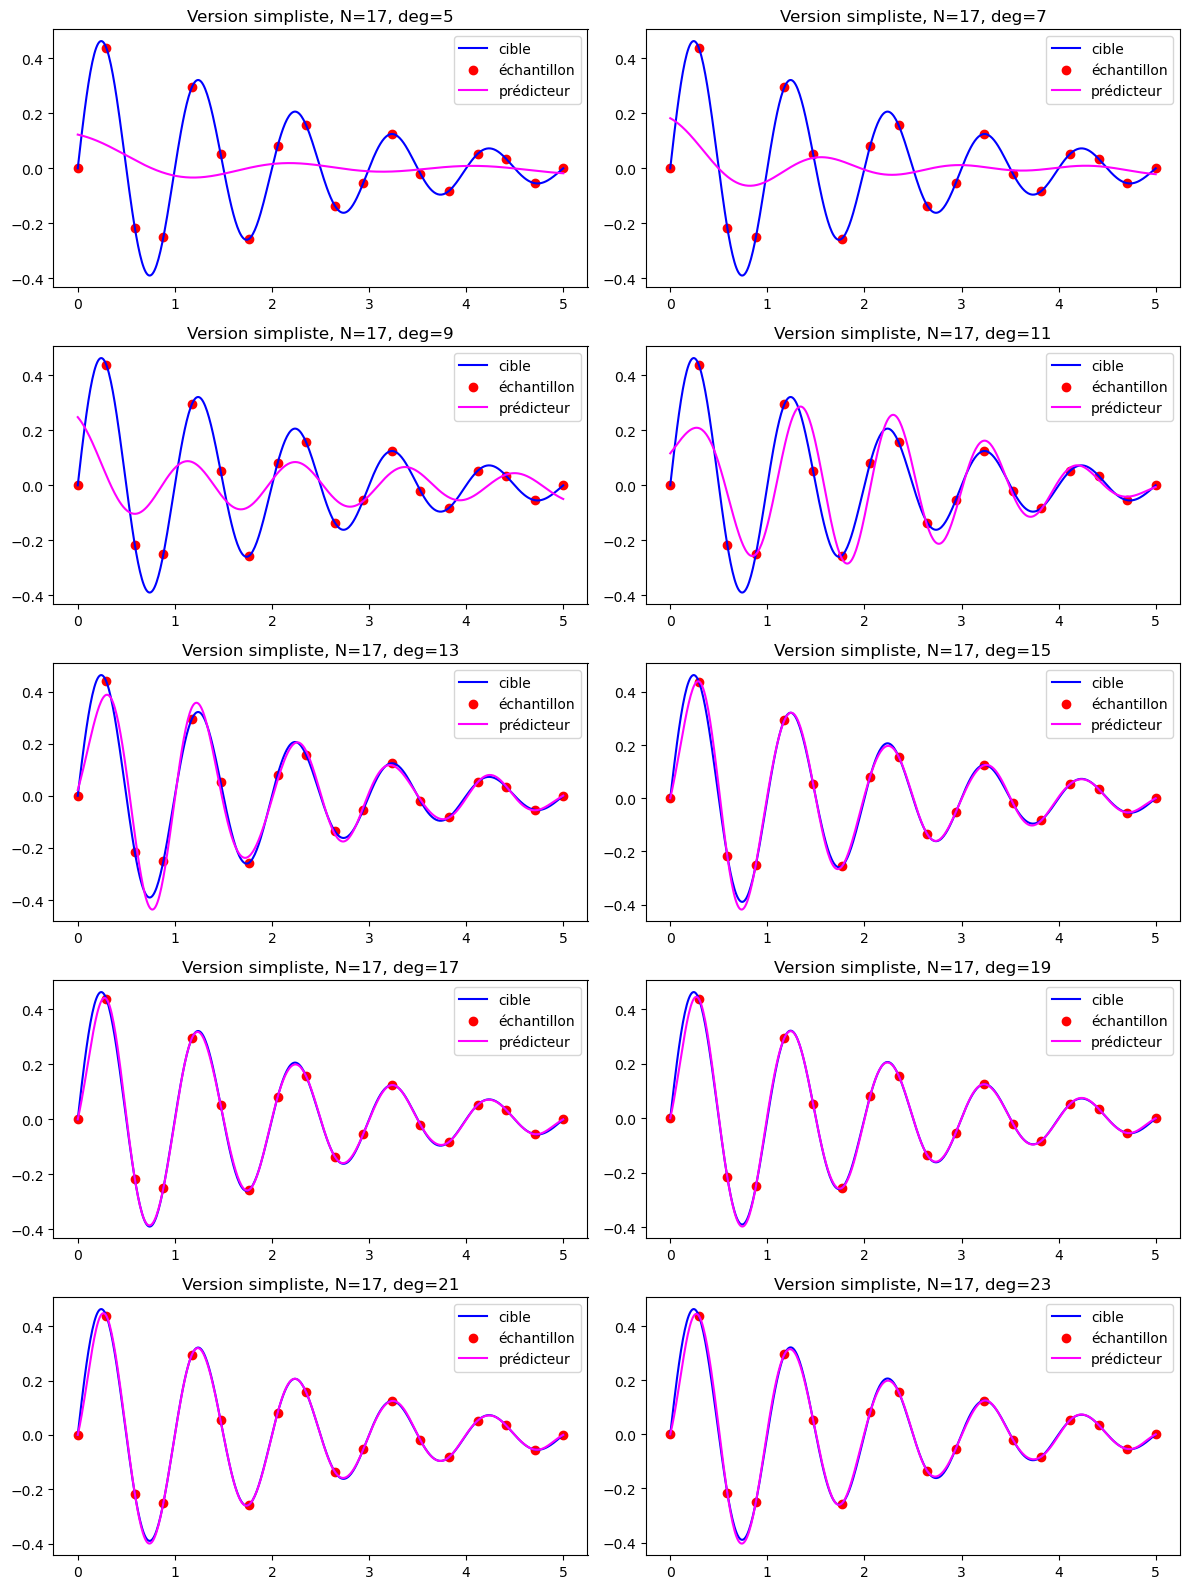

In [40]:
N = 17
ds = mod2ds_simpliste(modele=mod, N=N)

fig, reps = plt.subplots(nrows=5, ncols=2, tight_layout=True, figsize=(12, 16))

for deg, rep in zip(range(5, 30, 2), reps.flatten()):
    gauss = Gaussienne(degre=deg, L=mod.L)
    gauss.entrainement(ds)
    mod.affichage(rep)
    ds.affichage(rep)
    gauss.affichage(rep)
    rep.legend()
    rep.set_title(f"Version simpliste, {N=}, {deg=}")

In [38]:
gauss.coefficients

array([-149.05743634,  255.4546923 ,   20.9726111 , -199.19387966,
        -83.53235661,  145.71246729,  145.41642287,  -65.40077013,
       -170.86565325,  -25.81830701,  149.57039885,  102.60363284,
        -89.66456734, -145.01323942,   10.83377682,  145.31636933,
         64.01779705, -109.32840526, -117.10839696,   54.49765914,
        144.21285513,   -8.89966446, -173.51539424,   96.746468  ])

**EXERCICE**

Regarder ce que donne le modèle sur d'autres échantillonnage.

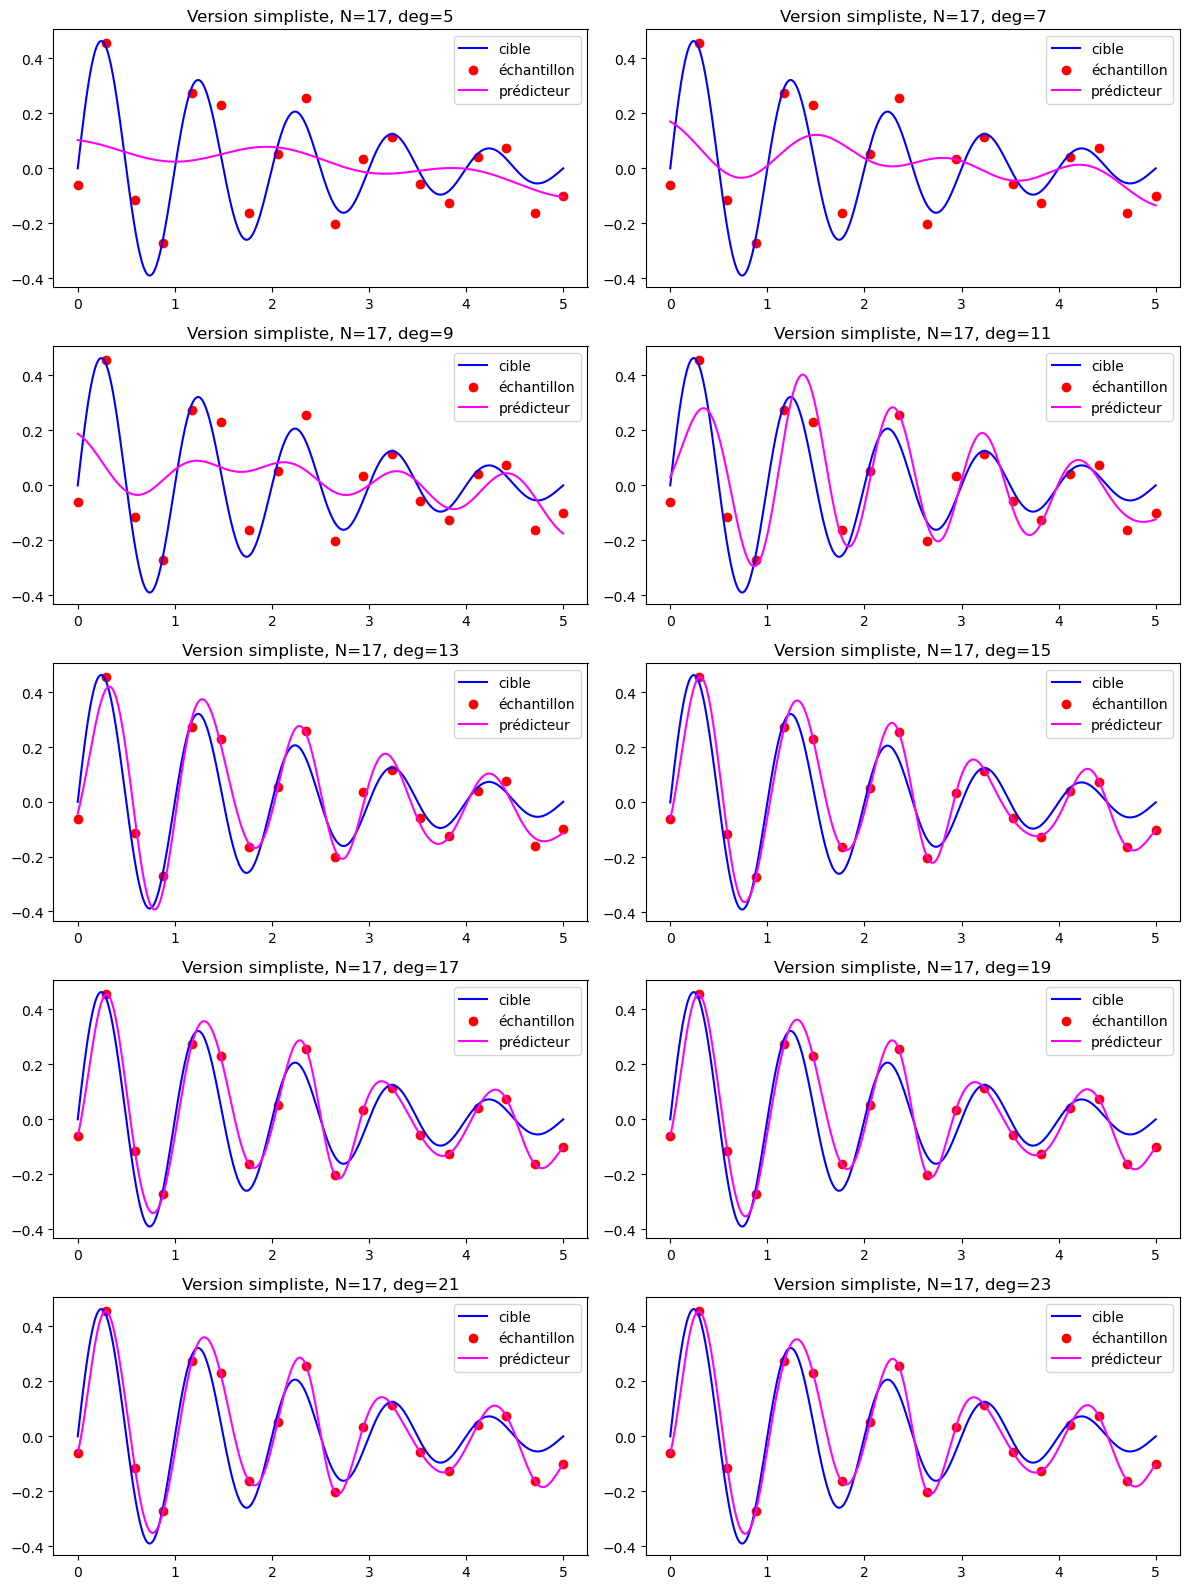

In [42]:
N = 17
ds = mod2ds_simple(modele=mod, N=N, epsilon=0.1)

fig, reps = plt.subplots(nrows=5, ncols=2, tight_layout=True, figsize=(12, 16))

for deg, rep in zip(range(5, 30, 2), reps.flatten()):
    gauss = Gaussienne(degre=deg, L=mod.L)
    gauss.entrainement(ds)
    mod.affichage(rep)
    ds.affichage(rep)
    gauss.affichage(rep)
    rep.legend()
    rep.set_title(f"Version simpliste, {N=}, {deg=}")

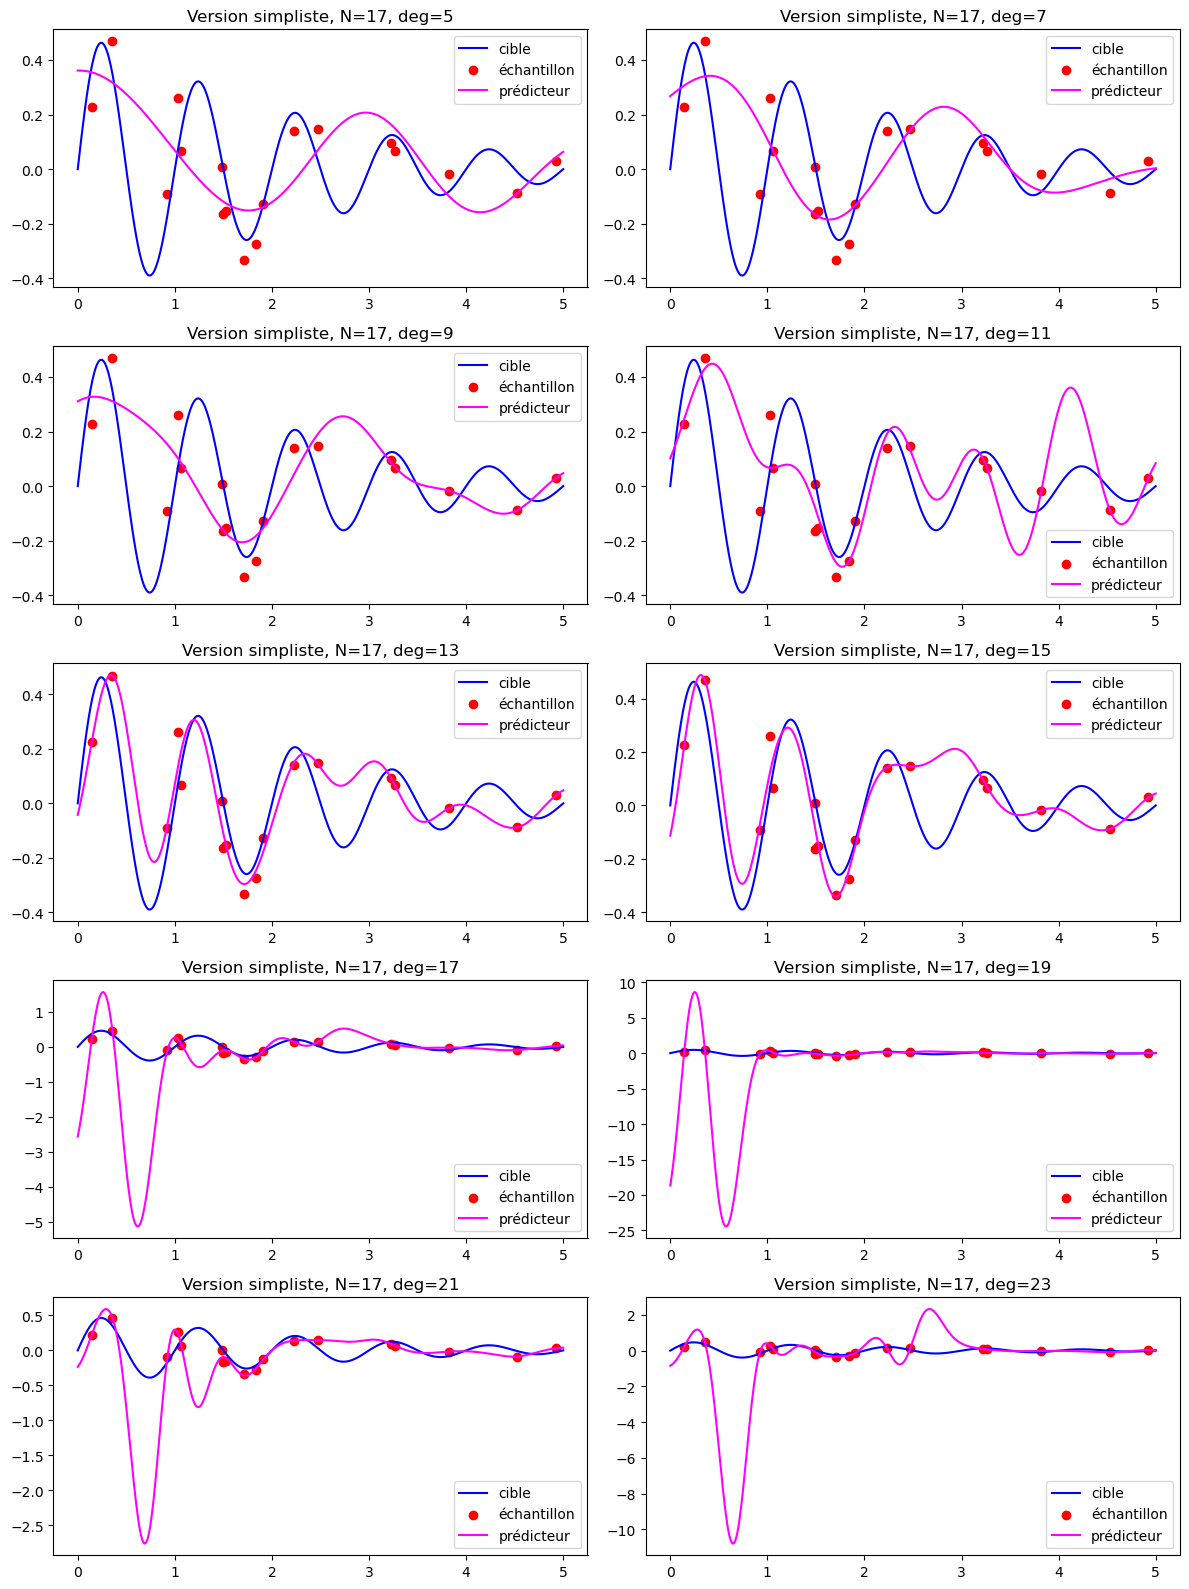

In [43]:
N = 17
ds = mod2ds(modele=mod, N=N, epsilon=0.1)

fig, reps = plt.subplots(nrows=5, ncols=2, tight_layout=True, figsize=(12, 16))

for deg, rep in zip(range(5, 30, 2), reps.flatten()):
    gauss = Gaussienne(degre=deg, L=mod.L)
    gauss.entrainement(ds)
    mod.affichage(rep)
    ds.affichage(rep)
    gauss.affichage(rep)
    rep.legend()
    rep.set_title(f"Version simpliste, {N=}, {deg=}")

On constate ici que quand le modèle est trop complexe par rapport à la taille du dataset, il y a des zones où le modèle généralise très mal (i.e. il est très loin de la courbe bleu). On parle de surapprentissage (overtraining) on apprend du bruit autant que du modèle caché.

Si au contraire le modèle manque de complexité, il ne peut meme pas reproduire le modèle caché.

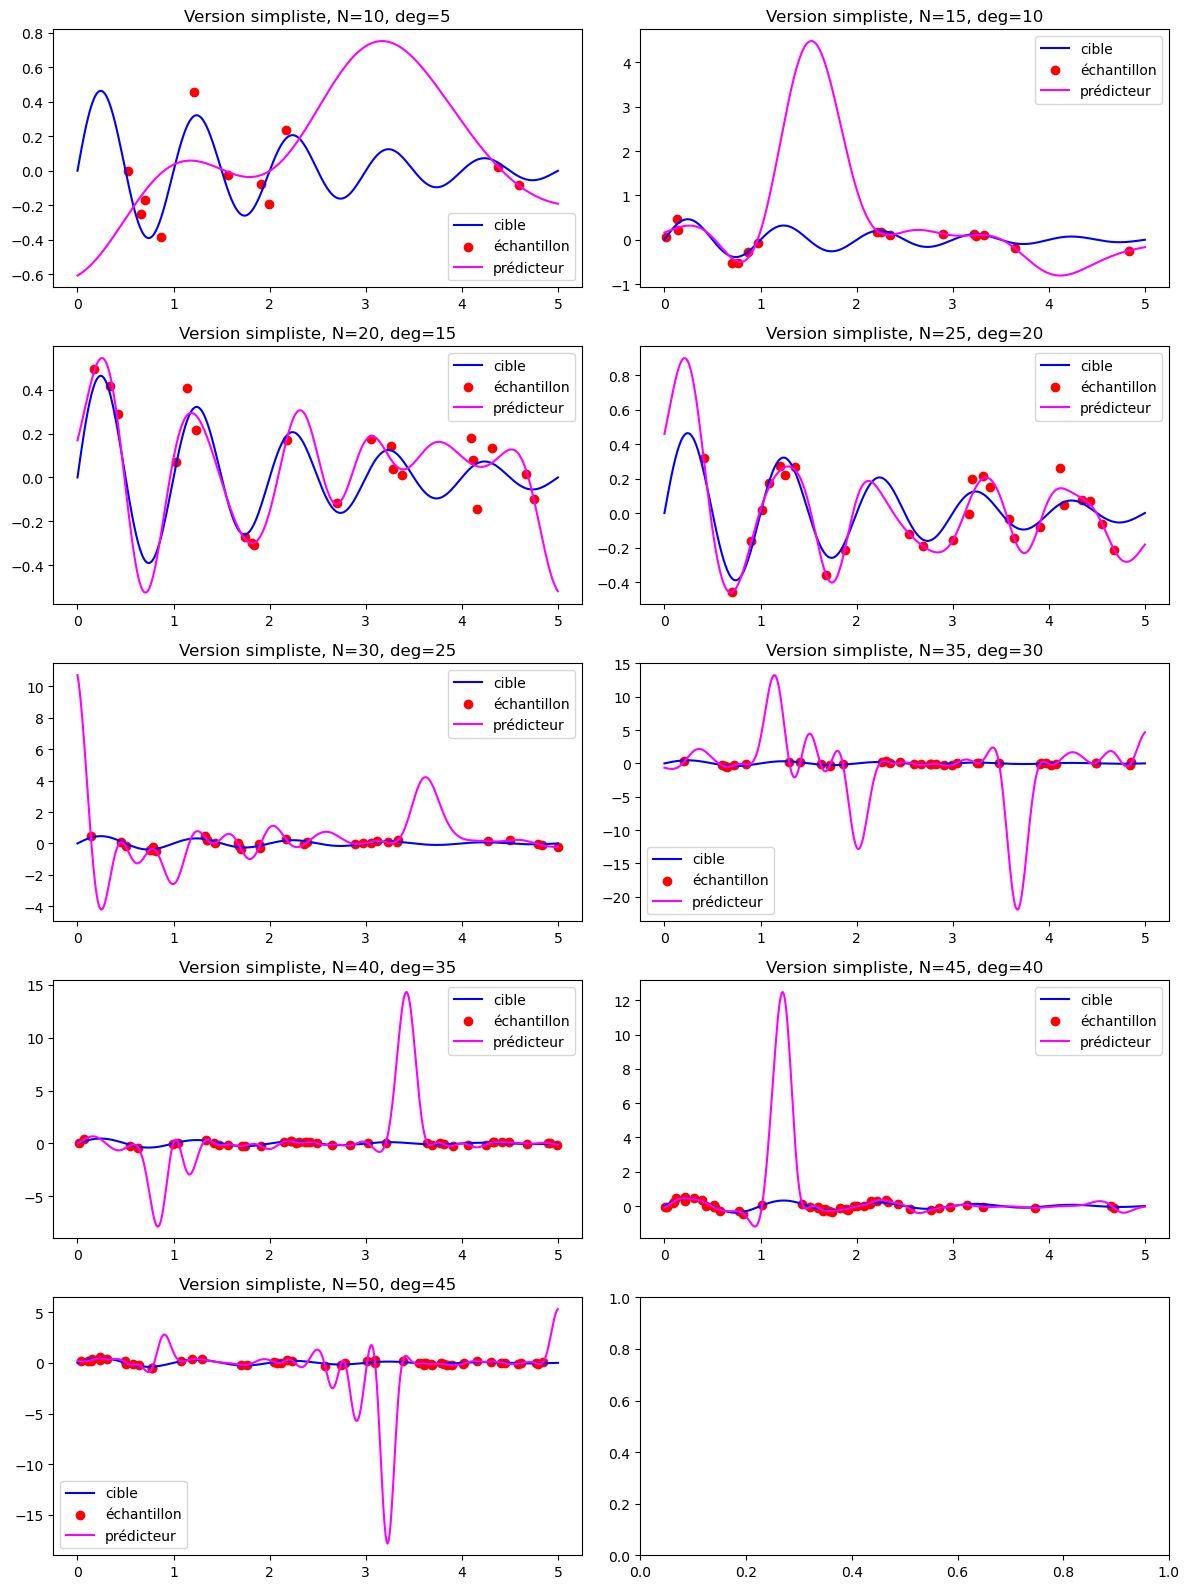

In [47]:
fig, reps = plt.subplots(nrows=5, ncols=2, tight_layout=True, figsize=(12, 16))
for deg, rep in zip(range(5, 50, 5), reps.flatten()):
    ds = mod2ds(modele=mod, N=deg + 5, epsilon=0.1)
    gauss = Gaussienne(degre=deg, L=mod.L)
    gauss.entrainement(ds)
    mod.affichage(rep)
    ds.affichage(rep)
    gauss.affichage(rep)
    rep.legend()
    rep.set_title(f"Version simpliste, N={deg+5}, {deg=}")

## Train Test split

La façon de garantir que le modèle n'est pas en surapprentissage est de découper l'échantillon en deux.
- Une partie servira à entrainer le modèle
- L'autre à évaluer la capacité du modèle à généraliser sur la partie du dataset qui n'a pas été vue.

Ce découpage sera probabiliste pour éviter des biais.

In [49]:
def train_test_split(ds: Dataset) -> tuple[Dataset, Dataset]:
    xtest, ytest, xtrain, ytrain = list(), list(), list(), list()
    for x, y in zip(ds.xk, ds.yk):
        if np.random.random() < 0.7:
            xtrain.append(x)
            ytrain.append(y)
        else:
            xtest.append(x)
            ytest.append(y)
    return Dataset(xtrain, ytrain), Dataset(xtest, ytest)

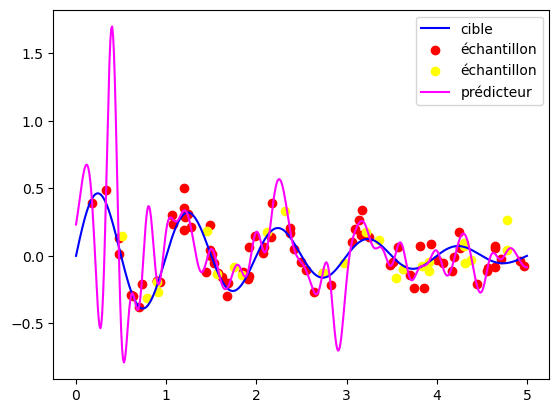

In [52]:
mod = Modele(L=5.)
ds = mod2ds(mod, 100, 0.1)
dstrain, dstest = train_test_split(ds)

fig,rep = plt.subplots()

mod.affichage(rep)
dstrain.affichage(rep, "red")
dstest.affichage(rep, "yellow")

gauss = Gaussienne(degre=50, L=mod.L)
gauss.entrainement(dstrain)
gauss.affichage(rep)
rep.legend()

In [53]:
gauss.erreur_quadratique(dstrain)

0.003701096245881485

In [54]:
gauss.erreur_quadratique(dstest)

0.05687751663937852

On voit un facteur 20 entre l'erreur sur la partie entrainement et sur la partie test.
On est déjà un peu en surapprentissage.

In [56]:
for degre in range(5, 50, 5):
    gauss = Gaussienne(degre=degre, L=mod.L)
    gauss.entrainement(dstrain)
    print(f"""
{degre=}
{gauss.erreur_quadratique(dstrain)}
{gauss.erreur_quadratique(dstest)}
          """
         )


degre=5
0.03788270149862887
0.030057924439813657
          

degre=10
0.023029544561424385
0.02934533049260242
          

degre=15
0.008165453795231297
0.010241045744504691
          

degre=20
0.007611730710382558
0.008013441206095973
          

degre=25
0.0073830920498565095
0.009168901907442809
          

degre=30
0.005685490967177233
0.017684394994868298
          

degre=35
0.005156145072385834
0.01506307971336588
          

degre=40
0.004249108622912368
0.018952177216968215
          

degre=45
0.004080297105780617
0.020191744355747606
          
